<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/ADME_A_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

In [2]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import math

def get_preds(threshold, probabilities):
    try:
        if probabilities.shape[1] == 2: probabilities = probabilities[:, 1]
    except: pass
    return [1 if prob > threshold else 0 for prob in probabilities]

def evaluate_model(TP, FP, TN, FN):

    ACCURACY = (TP + TN) / (TP+FP+TN+FN)
    SE = TP/(TP+FN)
    recall = SE
    SP = TN/(TN+FP)
    weighted_accuracy = (SE + SP) / 2

    precision = TP / (TP + FP)
    SP = TN/(TN+FP)
    F1 = 2 * precision * recall /(precision + recall)

    temp = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
    if temp != 0:
        MCC = (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
    else:
        print('equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))')
        print('TP, FP, TN, FN', TP, FP, TN, FN)
        print('temp=0')
        MCC = 'N/A'

    return ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC

def evaluate(y_real, y_hat, y_prob):
    TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()
    ACCURACY,SE, SP, weighted_accuracy, precision, F1, \
        MCC  = evaluate_model(TP, FP, TN, FN)
    try:
        if y_prob.shape[1] == 2: proba = y_prob[:, 1]
        else: proba = y_prob
    except: proba = y_prob
    AP = average_precision_score(y_real, proba)
    AUC = roc_auc_score(y_real, proba)
    print('Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP')
    if MCC != 'N/A':
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC),
      "&%8.3f" % (MCC), "&%8.3f" % (AP))
    else:
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC), "& ",
        MCC, "&%8.3f" % (AP))

    return ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP

In [5]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
import numpy as np
from tqdm import tqdm
"Reference: https://github.com/Yimeng-Wang/JAK-MTATFP/blob/main/preprocess.py"

from molvs.normalize import Normalizer, Normalization
from molvs.charge import Reionizer, Uncharger
import torch.nn as nn

from tdc.single_pred import ADME
from rdkit import RDLogger
import warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")
MASK = -100


def preprocess(smi):
    mol = Chem.MolFromSmiles(smi)
    normalizer = Normalizer()
    new1 = normalizer.normalize(mol)
    remover = SaltRemover()
    new2 = remover(new1)
    neutralize1 = Reionizer()
    new3 = neutralize1(new2)
    neutralize2 = Uncharger()
    new4 = neutralize2(new3)
    new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
    return new_smiles

In [97]:

name_reg = ['Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'VDss_Lombardo',
         'PPBR_AZ', 'Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB']

name_cls = ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
             'HIA_Hou', 'PAMPA_NCATS']

name_met_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                       'CYP1A2_Veith', 'CYP2C9_Veith',
                       'CYP2C9_Substrate_CarbonMangels',
                       'CYP2D6_Substrate_CarbonMangels',
                       'CYP3A4_Substrate_CarbonMangels']

# names = name_met_cls[:5] # metabolism

names = ['BBB_Martins', 'Bioavailability_Ma', 'HIA_Hou','PAMPA_NCATS']
IS_R = False # is regression task
SCALE = False

if IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
else: loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification

# If regression, metrics: R2, MAE, MSE, RMSE
# If classification, metrics: Loss, evaluate(y_real, y_hat, y_prob)

names, len(names)

(['BBB_Martins', 'Bioavailability_Ma', 'HIA_Hou', 'PAMPA_NCATS'], 4)

Found local copy...
Loading...
Done!


*************** BBB_Martins ***************


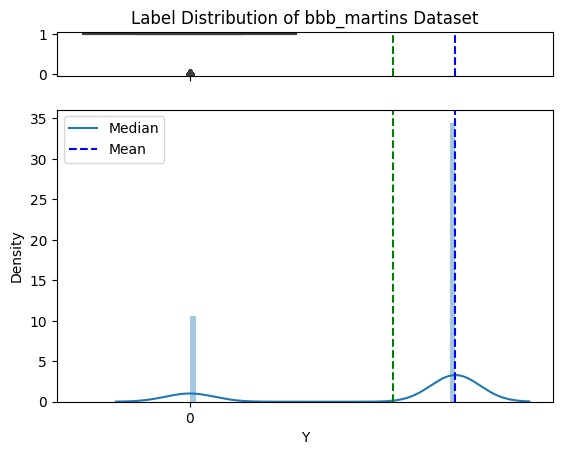

Cleaning mols: 100%|██████████| 406/406 [00:01<00:00, 345.13it/s]
Found local copy...
Loading...
Done!


*************** Bioavailability_Ma ***************


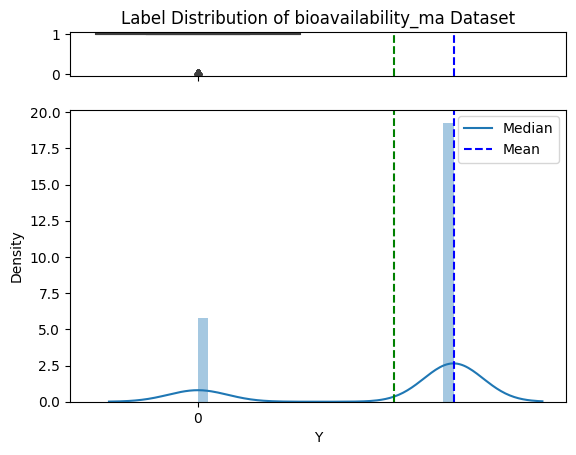

Cleaning mols: 100%|██████████| 128/128 [00:00<00:00, 353.81it/s]
Found local copy...
Loading...
Done!


*************** HIA_Hou ***************


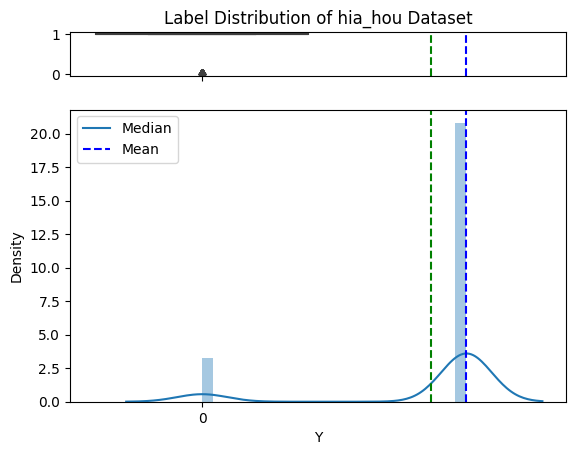

Cleaning mols: 100%|██████████| 116/116 [00:00<00:00, 369.35it/s]
Downloading...


*************** PAMPA_NCATS ***************


100%|██████████| 144k/144k [00:00<00:00, 554kiB/s]
Loading...
Done!


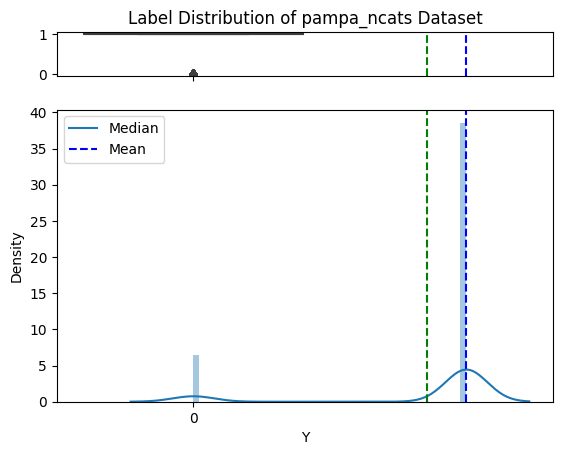

Cleaning mols: 100%|██████████| 407/407 [00:01<00:00, 354.62it/s]


(3465, 515, 1038)

In [98]:

def rename_cols(df, name): return df.rename(columns={'Y':name})

def clean_mol(df:pd.DataFrame):
    prev_len = len(df)
    for i in tqdm(range(len(df)), total=len(df), desc='Cleaning mols'):
        try: df.iloc[i]['Drug'] = preprocess(df.iloc[i]['Drug'])
        except: df.drop(i)
    if len(df) != prev_len: print(f'prev len: {prev_len}; after clean: {len(df)}')
    return df.reset_index(drop=True)

def scal(df): # min max scaling
    # df_norm = df.loc[:, df.columns!='Drug'].copy()
    df_norm = df.copy()
    for col in df_norm.columns:
        if col == 'Drug': pass
        else:
            df_norm[col] = (df_norm[col]-df_norm[col].min()
                )/(df_norm[col].max()-df_norm[col].min()) * 10
    # df_norm['Drug'] = df['Drug']
    return df_norm


for i, name in enumerate(names):
    print('*'*15, name, '*'*15)
    data = ADME(name=name)
    data.label_distribution()
    # data.convert_to_log(form='binding')

    # shoud not convert to log scale for the belowing since it is minus
    # Caco2_Wang                              -7.76
    # Lipophilicity_AstraZeneca               -1.45
    # HydrationFreeEnergy_FreeSolv           -23.62
    # Solubility_AqSolDB                   -13.1719

    split = data.get_split()
    train, valid = clean_mol(split['train']), clean_mol(split['valid'])
    test =  clean_mol(split['test'])

    train = rename_cols(train[['Drug', 'Y']], name)
    valid = rename_cols(valid[['Drug', 'Y']], name)
    test  = rename_cols(test[['Drug', 'Y']],  name)

    if IS_R and SCALE: train, valid, test = scal(train), scal(valid), scal(test)

    if i == 0: trains, valids, tests = train, valid, test
    else:
        trains = trains.merge(train, how='outer')
        valids = valids.merge(valid, how='outer')
        tests = tests.merge(test, how='outer')

# MASK = -100
# trains = trains.fillna(MASK)
# valids = valids.fillna(MASK)
# tests = tests.fillna(MASK)


# trains[trains.eq(0).any(1)]
# valids[valids.eq(0).any(1)]
# tests[tests.eq(0).any(1)]
len(trains), len(valids), len(tests)

In [99]:
trains

,Drug,BBB_Martins,Bioavailability_Ma,HIA_Hou,PAMPA_NCATS
0,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1.0,NaN,NaN,NaN
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1.0,NaN,NaN,NaN
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1.0,NaN,NaN,NaN
3,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1.0,NaN,NaN,NaN
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1.0,1.0,NaN,NaN
...,...,...,...,...,...
3460,COCCNC(=O)[C@H]1C[C@@H](CN1CC2=CC3=C(C=C2)NC=C...,NaN,NaN,NaN,1.0
3461,CC1=C(C(=CC=C1)N2C3=C(C=N2)C(CCC3)NC(=O)C4=C(C...,NaN,NaN,NaN,1.0
3462,COC(=O)CNC(=O)C1=NC(=C2N1C=CC=C2)C3=CC=C(C=C3)F,NaN,NaN,NaN,1.0
3463,CC1=CSC2=NC(=CN12)C3=CC(=CC=C3)NC(=O)C4=CC=CC=...,NaN,NaN,NaN,1.0


In [100]:
import pandas as pd

import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks


atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats_num = atom_featurizer.feat_size('hv')
e_feats_num = bond_featurizer.feat_size('he')

import time
named_tuple = time.localtime() # get struct_time
time_string = time.strftime("%m_%d_%Y_%H:%M:%S", named_tuple)

params = {'node_featurizer': atom_featurizer,
          'edge_featurizer': bond_featurizer,
          'smiles_column': 'Drug',
        #   'cache_file_path': time_string+'.bin',
          'task_names': names, 'load': True, 'n_jobs': len(names)}


train_datasets = MoleculeCSVDataset(trains, cache_file_path=f'train_{time_string}.bin', **params)
valid_datasets = MoleculeCSVDataset(valids,cache_file_path=f'valid_{time_string}.bin', **params)
test_datasets = MoleculeCSVDataset(tests, cache_file_path=f'test_{time_string}.bin', **params)

batch_size = 64
loader_params ={'batch_size': batch_size,
                'shuffle': True,
                'collate_fn': collate_molgraphs}

train_loader = DataLoader(train_datasets, **loader_params)
valid_loader = DataLoader(valid_datasets, **loader_params)
test_loader  = DataLoader(test_datasets,  **loader_params)

Processing dgl graphs from scratch...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 3465 out of 3465 | elapsed:    5.9s finished


Processing dgl graphs from scratch...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 515 out of 515 | elapsed:    0.5s finished


Processing dgl graphs from scratch...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1038 out of 1038 | elapsed:    1.3s finished


In [101]:
import time
def get_graph_dataset(df, name):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    # named_tuple =  # get struct_time
    time_string = time.strftime("%m_%d_%Y_%H:%M:%S", time.localtime())

    params = {'node_featurizer': atom_featurizer,
            'edge_featurizer': bond_featurizer,
            'smiles_column': 'Drug',
            'cache_file_path': time_string+'.bin',
            'task_names': name, 'load': True, 'n_jobs': len(name)}
    graph_dataset = MoleculeCSVDataset(df, **params)
    return graph_dataset


cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'
n_layers = 3
dropout = 0.5

model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names), dropout=dropout).to(device)

In [102]:
def train_epoch(epoch, model, data_loader, loss_func, optimizer):
    model.train()
    losses = 0
    train_meter = Meter()
    for batch_id, batch_data in tqdm(enumerate(data_loader),
                                     total=len(data_loader),
                                     desc=f'Epoch {epoch}'):
        smiles, bg, labels, masks = batch_data
        bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
        n_feats = bg.ndata.pop('hv').to(device)
        e_feats = bg.edata.pop('he').to(device)

        pred = model(bg, n_feats, e_feats)
        mask = masks < 1
        loss = loss_func(pred[~mask], labels[~mask])
        del mask
        # loss = (loss_func(pred, labels)*(masks!=0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
        del pred
        del labels
        del masks
        losses += loss.item()
        # losses.append(loss.item())

    total_r2 = np.mean(train_meter.compute_metric('r2'))
    total_loss = losses / len(data_loader.dataset)
    # if epoch % 10 == 0 and epoch != 0:
    print(f'[Train] R2: {total_r2:.3f}, Loss: {total_loss:.3f}')

    return total_r2, total_loss

def eval_epoch(model, data_loader, loss_func):
    model.eval()
    val_losses = 0
    eval_meter = Meter()
    with torch.no_grad():
        for batch_data in data_loader:
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            val_pred = model(bg, n_feats, e_feats)
            mask = masks < 1
            val_loss = loss_func(val_pred[~mask], labels[~mask])
            # val_loss = (loss_func(val_pred, labels)*(masks!=0).float()).mean()
            # val_losses.append(val_loss.item())
            val_losses += val_loss.item()
            eval_meter.update(val_pred, labels, masks)
            del val_pred
            del labels
            del masks
            del n_feats
            del e_feats
        total_score = np.mean(eval_meter.compute_metric('r2'))
        total_loss = val_losses / len(data_loader.dataset)
        print(f'[Valid] R2: {total_score:.3f}, Loss: {total_loss:.3f}')
    return total_score, total_loss

In [103]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
stopper = EarlyStopping(mode='lower', patience=30)
n_epochs = 500
best_epoch = 0
min_loss = 100000

In [ ]:

if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt_e.pt', map_location=device))

for epoch in range(best_epoch, best_epoch + n_epochs):
    score = train_epoch(epoch, model, train_loader, loss_fn, optimizer)
    val_score = eval_epoch(model, valid_loader, loss_fn)
    early_stop = stopper.step(val_score[1], model)
    if val_score[1] < min_loss and epoch > 3:
        print(f'prev min loss {min_loss:.3f}, now better loss {val_score[1]:.3f}')
        min_loss = val_score[1]
        torch.save(model.state_dict(), 'ckpt_e.pt')
        print(f'save model at epoch: {epoch}')
        best_epoch = epoch

    if early_stop: print('early stop'); break

In [105]:
model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names)).to(device)

model.load_state_dict(torch.load('ckpt_e.pt', map_location=device))


<All keys matched successfully>

In [106]:
import sklearn.metrics as metrics


def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    # print("Overall results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

In [107]:

print('Evaluate on test sets')
model = model.cpu()
model.eval()
total_loss = 0
test_meter = Meter()
if IS_R: print('using MSELoss')
else: print('using BCELOSSwithdigits')

for i, batch_data in tqdm(enumerate(test_loader), total=len(test_loader)):
    smiles, bg, labels, masks = batch_data
    # bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
    # n_feats = bg.ndata.pop('hv').to(device)
    # e_feats = bg.edata.pop('he').to(device)
    n_feats = bg.ndata.pop('hv')
    e_feats = bg.edata.pop('he')

    pred = model(bg, n_feats, e_feats)
    # loss = (loss_fn(pred, labels)*(masks!=0).float()).mean()
    mask = masks < 1
    loss = loss_fn(pred[~mask], labels[~mask])
    test_meter.update(pred, labels, masks)
    # print(loss)
    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
# masks_ = masks_ < 1
# preds_, labels_ = preds_.detach().numpy(), labels_.detach().numpy()
total_loss /= len(tests)
print(f'total_loss: {total_loss:.3f}')


Evaluate on test sets
using BCELOSSwithdigits


100%|██████████| 17/17 [00:01<00:00, 13.87it/s]

total_loss: 0.375


In [108]:

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

if IS_R: # regression task
    r2 = test_meter.compute_metric('r2')
    r2_mean, r2_std = np.mean(r2), np.std(r2)
    # r2_avg = test_meter.compute_metric('r2', reduction='mean')
    mae = test_meter.compute_metric('mae')
    mae_mean, mae_std = np.mean(mae), np.std(mae)
    # mae_avg = test_meter.compute_metric('mae', reduction='mean')
    rmse = test_meter.compute_metric('rmse')
    rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
    # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')
    print('\nOVERALL\n')
    print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
        f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
        f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

    print('\nSEPERATELY\n')
    for i, name in enumerate(names):

        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        fig = plt.figure()
        r2, mae, rmse = reg_evaluate(
                labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())
        color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())

        plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy(),
                    cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using AttentiveFP')


        x0, xmax = plt.xlim()
        y0, ymax = plt.ylim()
        data_width = xmax - x0
        data_height = ymax - y0
        # print(x0, xmax, y0, ymax, data_width, data_height)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

        plt.show()
        plt.cla()
        plt.clf()
        plt.close()

In [110]:
import torch.nn.functional as F
if IS_R == False:
    print('*'*20, 'OVERALL', '*'*20)
    probs = F.sigmoid(preds_[~masks_]).cpu().detach().numpy()
    label = labels_[~masks_].detach().numpy()
    preds = get_preds(0.5, probs)
    evaluate(label, preds, probs)
    print()
    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()

******************** OVERALL ********************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.841  &  0.674  &          0.854  &     0.963  &0.386  &0.905 &0.855 &   0.453 &   0.951

*************** BBB ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.835  &  0.739  &          0.858  &     0.934  &0.544  &0.894 &0.880 &   0.533 &   0.947

*************** Bioavailability ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.688  &  0.512  &          0.708  &     0.944  &0.079  &0.810 &0.709 &   0.044 &   0.855

*************** HIA ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.966  &  0.895  &          0.960  &     1.000  &0.789  &0.980 &0.995 &   0.871 &   0.999

*************** PAMPA ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     A